In [19]:
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import pandas as pd

## Data Argumentation

In [20]:
filepaths = sorted(glob.glob('../../Data/separate/front/*.png'))
filepaths[:5]

['../../Data/separate/front/front_00001.png',
 '../../Data/separate/front/front_00002.png',
 '../../Data/separate/front/front_00003.png',
 '../../Data/separate/front/front_00004.png',
 '../../Data/separate/front/front_00005.png']

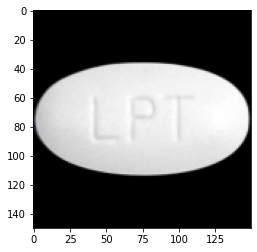

In [21]:
#cv2.imread는 이미지를 RGB가 아닌 BGR로 받아오기 때문에 바꿔 주어야함.
image = cv.cvtColor(cv.imread(filepaths[5]), cv.COLOR_BGR2RGB)
plt.imshow(image)

In [22]:
def show_aug_image(image, generator, n_images=4):
	
    # ImageDataGenerator는 여러개의 image를 입력으로 받기 때문에 4차원으로 입력 해야함.
    image_batch = np.expand_dims(image, axis=0)
	
    # featurewise_center or featurewise_std_normalization or zca_whitening 가 True일때만 fit 해주어야함
    generator.fit(image_batch) 
    # flow로 image batch를 generator에 넣어주어야함.
    data_gen_iter = generator.flow(image_batch)

    fig, axs = plt.subplots(nrows=1, ncols=n_images, figsize=(24, 8))

    for i in range(n_images):
    	#generator에 batch size 만큼 augmentation 적용(매번 적용이 다름)
        aug_image_batch = next(data_gen_iter)
        aug_image = np.squeeze(aug_image_batch)
        aug_image = aug_image.astype('int')
        axs[i].imshow(aug_image)

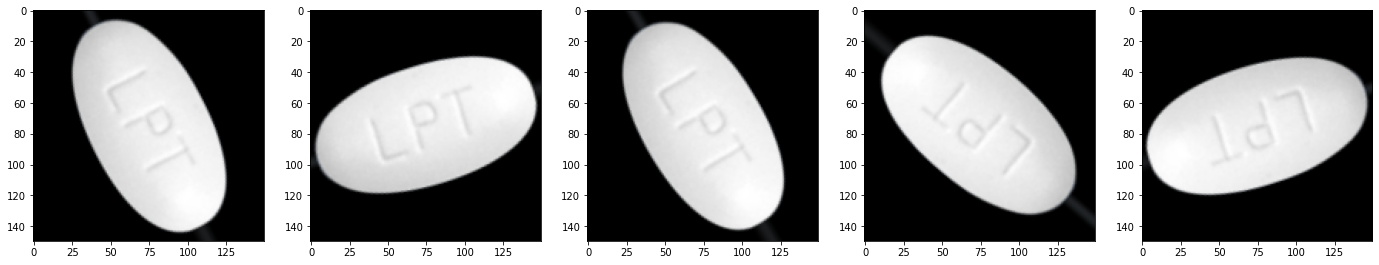

In [23]:
data_generator = ImageDataGenerator(rotation_range=180)
show_aug_image(image, data_generator, n_images=5)

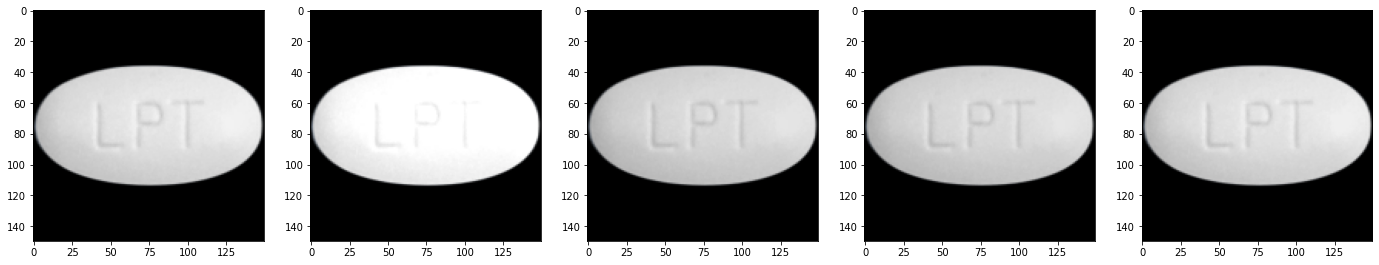

In [24]:
data_generator = ImageDataGenerator(brightness_range=[0.9,1.1])
show_aug_image(image, data_generator, n_images=5)

## Make Train Data

In [25]:
# 메타 데이터 불러오기
label_df = pd.read_csv("../../Data/pill_kr_reduce.csv", encoding='utf-8')[['PRINT_FRONT', 'PRINT_BACK', 'MARK_CODE_FRONT_ANAL', 'MARK_CODE_BACK_ANAL']]

/tmp/ipykernel_153495/1832260593.py:2: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  label_df = pd.read_csv("../../Data/pill_kr_reduce.csv", encoding='utf-8')[['PRINT_FRONT', 'PRINT_BACK', 'MARK_CODE_FRONT_ANAL', 'MARK_CODE_BACK_ANAL']]


In [26]:
# 마크 -> 마크코드로 대치
for i, row in label_df.iterrows():
    if '마크' in str(row['PRINT_FRONT']) and not pd.isnull(row['MARK_CODE_FRONT_ANAL']):
        temp = row['PRINT_FRONT'].replace('마크', str(row['MARK_CODE_FRONT_ANAL']))
        label_df.loc[i, 'PRINT_FRONT'] = temp

    if '마크' in str(row['PRINT_BACK']) and not pd.isnull(row['MARK_CODE_FRONT_ANAL']):
        temp = row['PRINT_BACK'].replace('마크', str(row['MARK_CODE_BACK_ANAL']))
        label_df.loc[i, 'PRINT_BACK'] = temp

In [27]:
# 앞/뒤 각인 1개 칼럼으로 통합
label_df = pd.concat((label_df.PRINT_FRONT, label_df.PRINT_BACK), axis=0).reset_index(drop=True)
labels = pd.Series(label_df, name='Label').astype(str)
labels

0          IDG
1           YH
2           KD
3          ISP
4        V분할선T
         ...  
46635       TC
46636      850
46637      nan
46638       VG
46639      nan
Name: Label, Length: 46640, dtype: object

In [28]:
labels.value_counts()

nan           11487
분할선            1820
마크              698
10              377
5               306
              ...  
LVE               1
NKGH              1
SP ZEROSAL        1
NKAC              1
FZ                1
Name: Label, Length: 14526, dtype: int64

In [29]:
# 파일 경로 추출 (앞/뒤 순서)
filepaths = sorted(glob.glob('../../Data/separate/front/*.png')) + sorted(glob.glob('../../Data/separate/back/*.png'))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
filepaths

0        ../../Data/separate/front/front_00001.png
1        ../../Data/separate/front/front_00002.png
2        ../../Data/separate/front/front_00003.png
3        ../../Data/separate/front/front_00004.png
4        ../../Data/separate/front/front_00005.png
                           ...                    
46635      ../../Data/separate/back/back_23316.png
46636      ../../Data/separate/back/back_23317.png
46637      ../../Data/separate/back/back_23318.png
46638      ../../Data/separate/back/back_23319.png
46639      ../../Data/separate/back/back_23320.png
Name: Filepath, Length: 46640, dtype: object

In [30]:
# 파일 경로와 각인 합치기
df = pd.concat([filepaths, labels], axis=1)
df

,Filepath,Label
0,../../Data/separate/front/front_00001.png,IDG
1,../../Data/separate/front/front_00002.png,YH
2,../../Data/separate/front/front_00003.png,KD
3,../../Data/separate/front/front_00004.png,ISP
4,../../Data/separate/front/front_00005.png,V분할선T
...,...,...
46635,../../Data/separate/back/back_23316.png,TC
46636,../../Data/separate/back/back_23317.png,850
46637,../../Data/separate/back/back_23318.png,nan
46638,../../Data/separate/back/back_23319.png,VG


In [31]:
# x, y 데이터 구축
x = []
y = []
class_dict = dict()
num = 0
for i, row in df.iterrows():
    if i % 1000 == 0:
        print(i)
    if row['Label'] == '마크':
        y.append(num)
        num += 1
    else:
        if row['Label'] not in class_dict.keys():
            class_dict[row['Label']] = num
            num += 1
        y.append(class_dict[row['Label']])
    img = cv.imread(row['Filepath'], cv.IMREAD_GRAYSCALE)
    img = cv.equalizeHist(img)
    img = cv.fastNlMeansDenoising(img, None, 10, 7, 21)
    x.append(img)

x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)
print(num)

0


KeyboardInterrupt: 

In [ ]:
# 데이터 저장
np.savez('data.npz',x=x,y=y)

## Update Label to csv

In [33]:
# 레이블 데이터 불러오기
df = pd.read_csv("../../Data/pill_labels.csv", encoding='utf-8')

In [34]:
df['PRINT_FRONT'] = 0
df['PRINT_BACK'] = 0

In [39]:
data_num = len(df)

for i in range(data_num):
    df.loc[i, 'PRINT_FRONT'] = y[i]
    df.loc[i, 'PRINT_BACK'] = y[i+data_num]
df

IndexError: list index out of range

In [ ]:
df.to_csv("../../Data/pill_labels.csv", encoding='utf-8', index=False)